# Load Data
- MNIST

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
def data_generator(root, batch_size):
    train_set = datasets.MNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.MNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

# Model

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils import weight_norm

In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        # chomp_size(padding size): (kernel_size-1) * dilation_size 
        self.chomp_size = chomp_size  

    def forward(self, x):
        # output: (N, C_in, L_in - chomp_size)
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        #--------------------- Dilated Causal Convolution --------------------- 
        '''
        input: (N, C_in, L_in) -> (N, C_out, L_in)
        output sequence의 길이는 변하지 않는다. 
        '''
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        #----------------------------------------------------------------------
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        #--------------------- Dilated Causal Convolution --------------------- 
        '''
        input: (N, C_in, L_in) -> output: (N, C_out, L_in)
        output sequence의 길이는 변하지 않는다. 
        '''
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        #----------------------------------------------------------------------
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Dilated Causal Conv -> WeightedNorm -> ReLU -> Dropout -> ... (논문의 Residual block 구조와 동일)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        # Residual Connections 
        '''  
        만약 Dilated Causal Conv를 적용하기 전의 input channel과 적용한 후의 
        output channel이 달라질 경우를 대비하여 추가적인 1*1 convolution을 추가해줌.

        input: (N, C_in, L_in) -> output: (N, C_out, L_in)
        output sequence의 길이는 변하지 않는다. (1*1 convolution)
        '''  
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            # dilation factor는 layer의 깊이에 지수적으로 증가 (2^i, i: layer depth) 
            dilation_size = 2 ** i 
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            # 설정된 layer의 깊이만큼 TemporalBlock 생성 
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """
        Inputs have to have dimension (N, C_in, L_in)
        Flatten된 MNIST의 경우에는 (batch_size, 1, 784)
        """
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1]) # sequence의 마지막 time step로 linear계산 -> 분류예측
        return F.log_softmax(o, dim=1)

# Config

In [ ]:
import numpy as np

In [ ]:
batch_size = 64
cuda = torch.cuda.is_available()
dropout = 0.05
epochs = 20
ksize = 7
levels = 8
log_interval = 100
lr = 2e-3
optim = 'Adam'
clip=-1
nhid = 25
seed = 1004
permute = False
n_classes = 10
input_channels = 1
seq_length = int(784 / input_channels)
root = './'

# Train

In [ ]:
def train(ep):
    global steps
    train_loss = 0
    model.train()

    loss_lst = []
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda: data, target = data.cuda(), target.cuda()
        data = data.view(-1, input_channels, seq_length)
        if permute:
            data = data[:, :, permute]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss
        steps += seq_length
        loss_lst.append(train_loss.item()/log_interval)
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()/log_interval, steps))
            train_loss = 0

    return np.mean(loss_lst)


def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, input_channels, seq_length)
            if permute:
                data = data[:, :, permute]
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        return test_loss

In [ ]:
steps = 0
train_loader, test_loader = data_generator(root, batch_size)
channel_sizes = [nhid] * levels

print(channel_sizes)

[25, 25, 25, 25, 25, 25, 25, 25]


In [ ]:
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=ksize, dropout=dropout)

if cuda:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_hist = np.zeros(epochs)
test_hist = np.zeros(epochs)

for epoch in range(1, epochs+1):
    train_loss = train(epoch)
    test_loss = test()
    train_hist[epoch] = train_loss
    test_hist[epoch] = test_loss

    if epoch % 10 == 0:
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.041101	Steps: 6607552
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.045729	Steps: 6685952
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.039530	Steps: 6764352
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.039536	Steps: 6842752
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.046653	Steps: 6921152
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.045956	Steps: 6999552
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.064901	Steps: 7077952
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.072180	Steps: 7156352
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.051976	Steps: 7234752


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0719, Accuracy: 9779/10000 (98%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.047974	Steps: 7342944
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.040478	Steps: 7421344
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.035321	Steps: 7499744
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.037890	Steps: 7578144
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.039100	Steps: 7656544
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.051952	Steps: 7734944
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.047769	Steps: 7813344
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.059327	Steps: 7891744
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.048469	Steps: 7970144

Test set: Average loss: 0.0464, Accuracy: 9848/10000 (98%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.043620	Steps: 8078336
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.038982	Steps: 8156736
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.040510	Steps: 8235136
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.040817	Steps: 8313536
Train Epoch: 3 [32000/60000 (53%)]	

In [ ]:
train_hist

array([0.        , 0.0245454 , 0.02305721, 0.02256827, 0.02040119,
       0.01936794, 0.01785436, 0.01663967, 0.0158856 , 0.01587617,
       0.01520845, 0.01001553, 0.00738936, 0.00711028, 0.00657757,
       0.0057308 , 0.00544827, 0.00526195, 0.00564256, 0.00508863])

In [ ]:
test_hist

array([0.        , 0.0718815 , 0.04639563, 0.04574487, 0.0431038 ,
       0.04879621, 0.04306144, 0.04292579, 0.04088197, 0.05112413,
       0.04387851, 0.03339606, 0.03346706, 0.03421258, 0.03442019,
       0.03458437, 0.03437225, 0.03504209, 0.03561838, 0.03612663])

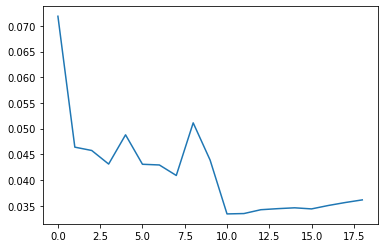

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(19), test_hist[1:])

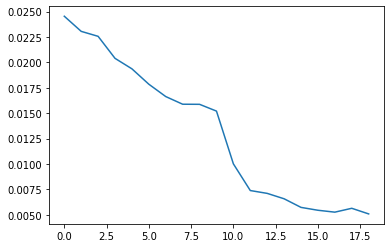

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(19), train_hist[1:])

In [2]:
print('hello')

hello
